# DS-6014 Bayesian Machine Learning Final Project
#### Haizhu Hong, Yiran Zheng

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

### load the data

In [2]:
# historical news headlines from Reddit WorldNews Channel (/r/worldnews). 
#They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date.
news=pd.read_csv("../data/RedditNews.csv")
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [3]:
#Dow Jones Industrial Average (DJIA) is used to "prove the concept".
stock=pd.read_csv("../data/upload_DJIA_table.csv")
stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [4]:
#date is the date and followed by top25 topics in redditnews,
#label is binary classification:
#"1" when DJIA Adj Close value rose or stayed as the same;
#"0" when DJIA Adj Close value decreased.

combined=pd.read_csv("../data/Combined_News_DJIA.csv")
combined.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

### data cleaning and preprocessing

### First check if there is any Null value in the data

In [5]:
news.isnull().values.any()

False

In [6]:
stock.isnull().values.any()

False

In [7]:
combined.isnull().values.any()

True

In [8]:
#try to locate the null value in the combined data
combined.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [9]:
# filling the null values with " "
combined['Top23'].fillna(" ",inplace=True)
combined['Top24'].fillna(" ",inplace=True)
combined['Top25'].fillna(" ",inplace=True)

In [10]:
# Set stop words
stopWords = set(stopwords.words('english'))
# This preprocessing step just removes stopwords
def preprocessor(text): 
    tokens = nltk.word_tokenize(text)
    return (" ").join([word for word in tokens if word not in stopWords])

In [11]:
Tops=[x for x in combined.columns if x.startswith("Top")]
for Top in Tops:
    combined[Top]= combined[Top].apply(preprocessor)
combined[Tops].head()
combined['headlines']=combined[Tops].apply(lambda x: ",".join(x.astype(str)), axis=1)

In [12]:
#remove punctuation and lower case all the news headlines
for i in combined.columns:
    if i=='Date':
        continue
    if i=='Label':
        continue
    combined[i].replace("[^a-zA-Z]"," ",regex=True, inplace=True)
    combined[i]= combined[i].str.lower()


### EDA 

### split the data into training and testing dataset

In [13]:
#data from 2008-08-08 to 2014-12-31 as Training Set, 
#and Test Set is then the following two years data (from 2015-01-02 to 2016-07-01). 
#This is roughly a 80%/20% split.
train = combined[combined['Date'] < '2015-01-01']
test = combined[combined['Date'] > '20141231']
train.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,headlines
0,2008-08-08,0,b georgia downs two russian warplanes co...,b breaking musharraf impeached,b russia today columns troops roll south oss...,b russian tanks moving towards capital south o...,b afghan children raped impunity u n ...,b russian tanks entered south ossetia whil...,b breaking georgia invades south ossetia ...,b the enemy combatent trials nothing sha...,...,b al qaeda faces islamist backlash,b condoleezza rice the us would act preve...,b this busy day the european union approved ...,b georgia withdraw soldiers iraq help...,b why pentagon thinks attacking iran bad idea ...,b caucasus crisis georgia invades south osse...,b indian shoe manufactory and series like...,b visitors suffering mental illnesses banned o...,b no help mexico s kidnapping surge,b georgia downs two russian warplanes co...
1,2008-08-11,1,b why wont america nato help us if wont help...,b bush puts foot georgian conflict,b jewish georgian minister thanks israeli...,b georgian army flees disarray russians advanc...,b olympic opening ceremony fireworks faked...,b what mossad fraudulent new zealand passports...,b russia angered israeli military sale georgia,b an american citizen living s ossetia blames ...,...,b do believe tv neither russian georgia...,b riots still going montreal canada police...,b china overtake us largest manufacturer,b war south ossetia pics,b israeli physicians group condemns state tort...,b russia beaten united states head peak oil,b perhaps question georgia russia confli...,b russia much better war,b so s come trading sex food,b why wont america nato help us if wont help...
2,2008-08-12,0,b remember adorable year old sang opening ce...,b russia ends georgia operation,b if sexual harassment would children ...,b al qa eda losing support iraq brutal crac...,b ceasefire georgia putin outmaneuvers west,b why microsoft intel tried kill xo lapt...,b stratfor the russo georgian war balance po...,b i m trying get sense this whole georgia ...,...,b why russias response georgia right,b gorbachev accuses u s making serious blu...,b russia georgia nato cold war two,b remember adorable year old led country wa...,b war georgia the israeli connection,b all signs point us encouraging georgia invad...,b christopher king argues us nato behind georg...,b america the new mexico,b bbc news asia pacific extinction by ...,b remember adorable year old sang opening ce...
3,2008-08-13,0,b u s refuses israel weapons attack iran ...,b when president ordered attack tskhinvali ...,b israel clears troops killed reuters camera...,b britain s policy tough drugs pointless ...,b body year old found trunk latest rans...,b china moved million quake survivors p...,b bush announces operation get all up in ru...,b russian forces sink georgian ships,...,b us humanitarian missions soon georgia russ...,b georgia s ddos came us sources,b russian convoy heads georgia violating tru...,b israeli defence minister us strike iran,b gorbachev we had no choice,b witness russian forces head towards tbilis...,b quarter russians blame u s conflict poll,b georgian president says us military take con...,b nobel laureate aleksander solzhenitsy...,b u s refuses israel weapons attack iran ...
4,2008-08-14,1,b all experts admit legalise drugs,b war south osetia pictures made russian ...,b swedish wrestler ara abrahamian throws away ...,b russia exaggerated death toll south ossetia ...,b missile that killed inside pakistan may ha...,b rushdie condemns random house s refusal ...,b poland us agree missle defense deal intere...,b will russians conquer tblisi bet serious...,...,b georgia confict could set back russia s ...,b war caucasus much product american imperial ...,b non media photos south ossetia georg...,b georgian tv reporter shot russian sniper liv...,b saudi arabia mother moves block child marr...,b taliban wages war humanitarian aid workers,b russia world forget georg

In [14]:
test.reset_index(inplace=True,drop=True)
test

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,headlines
0,2015-01-02,1,most cases cancer result sheer bad luck rather...,iran dismissed united states efforts fight isl...,poll one germans would join anti muslim ma...,uk royal family s prince andrew named us laws...,some asylum seekers refused leave bus arriv...,pakistani boat blows self india navy chase a...,sweden hit third mosque arson attack week,cars set alight french new year,...,palestinian president mahmoud abbas entered se...,israeli security center publishes names kil...,the year deadliest year yet syria s four...,a secret underground complex built nazis may u...,restrictions web freedom major global issue,austrian journalist erich mchel delivered pres...,thousands ukraine nationalists march kiev,chinas new years resolution no more harvesti...,authorities pull plug russia s last political...,most cases cancer result sheer bad luck rather...
1,2015-01-05,0,moscow gt beijing high speed train reduce...,two ancient tombs discovered egypt sunday on...,china complains pyongyang n korean soldier kil...,scotland headed towards being fossil fuel free...,prime minister shinzo abe said monday express ...,sex slave centre prince andrew scandal fled au...,gay relative hamas founder faces deportation c...,the number female drug addicts iran almost dou...,...,iceland to withdraw eu application lift capi...,blackfield capital founder goes missing the ...,rocket stage crashes back earth rural chinese ...,dead aircraft bombs greek tanker libyan port,belgian murderer frank van den bleeken die req...,czech president criticizes ukrainian pm says...,vietnamese jets join search missing filip...,france seeks end russia sanctions ukraine,china scraps rare earths caps,moscow gt beijing high speed train reduce...
2,2015-01-06,0,us oil falls barrel,toyota gives away fuel cell patents buil...,young indian couple granted police protection ...,a senior figure islamic states self declared p...,fukushima rice passes radiation tests st time...,nearly spanish parties guilty financial crimes...,king abdullah abdicate saudi throne,taliban commander caught networking on linkedin,...,turkey sacks judges oversaw erdogan corruption...,spacex falcon launch recovery aborted next...,cnn americans charged botched gambia coup,islamic state police official beheaded,libya bans palestinians country prevent entry ...,a judicial inquiry opened france monday inmate...,video captured moment cameraman hurled backwar...,syria complained united nations u s republica...,tests india set make iris biggest telescope ...,us oil falls barrel toyota gives away ...
3,2015-01-07,1,shots fired french magazine hq,bibi netanyahus campaign funds from u s,isis behead street magician entertaining crowd...,denmark sets new world record renewable energy...,isis closes schools in syria leaving ...,the european union wants turkey explain human ...,people died shooting headquarters french sa...,most earth like planet ever discovered could c...,...,radical islam growing threat sub saharan chris...,tony blair may face war crime charges iraq ...,benjamin netanyahu says settlements unlikely d...,tasmania moves allow corporations sue proteste...,indonesia search chief tail section airasia ...,north korean defector bureau hacke...,female suicide bomber attacks police station i...,is turn syria schools religious indoctrination...,ebola vaccine trials halifax far success,shots fired french magazine hq bibi ne...
4,2015-01-08,1,new charlie hebdo issue come next week it...,ahmed merabet cop killed in paris attacks ...,youngest suspect charlie hebdo attack turns hi...,grenades thrown mosque le mans west paris,danish newspaper print charlie hebdo cartoons ...,muslim politician india offers m charlie he...,vladimir putin condemned deadly terrorist atta...,turkey trying hide evidence holds turkish lead...,...,journalists race show solidarity charlie hebd...,antibiotics us discovery labelled ga

### Build LDA model to predict topics and word 

In [15]:
class LDA_trains:
    """Creates a class for Latent Dirichlet Allocation using headlines in redditnews
    Input:
        reports = list of headlines
        N_topics = number of topics for LDA to produce
        N_words = the number of words to show in a topic
        new_report = narrative for a new accident report not in the training set
    Methods:
        Topics = Print the list of topics in the selected headlines
        Predict_Topics = Show the predicted probabilities for topics for a new headlines"""
    
    def __init__(self, headlines, N_topics=3, N_words = 10):
        # the news headlines
        self.headlines = headlines
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        
        # Get the word counts in the headlines
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.termFrequency = self.countVectorizer.fit_transform(self.headlines)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        
        # Obtain the estimates for the LDA model 
        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        # For each of the topics in the model add the top N_words the list of topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i] for i in topic.argsort()[:-self.N_words - 1:-1]])
        # Create column names for the output matrix
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i)))
            
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe 
        Topics_df =pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"        
        return Topics_df
    
    def Predict_Topics(self, new_headlines):
        self.new_headlines = new_headlines
        # Get the list of new headlines
        # and the number of new narratives
        N_new_headlines = len(self.new_headlines)
        
        
        # For each of the new headlines 
        # obtain the estimated probabilities for each of the topics
        # in each of the new narratives as estimated by the LDA results
        # on the training set 
        new_headlines_topics = list()
        for title in self.new_headlines:
            new_headlines = preprocessor(title)
            new_headlines_topics.append(self.lda.transform(self.countVectorizer.transform([new_headlines])))       
        
        # Recast the list of probabilities for topics as an array 
        # of size no. of new headlines X no. of topics
        new_headlines_topics = np.array(new_headlines_topics).reshape(N_new_headlines, self.N_topics)
        
        # Create column names for the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic_"+(str(i)))        
        
        # Create the dataframe whose rows contain topic probabilities for 
        # specificed narratives/headlines
        New_Headlines_df = pd.DataFrame(new_headlines_topics, columns = cols )
        New_Headlines_df.insert(0, 'headlines', self.new_headlines)       
        
        return New_Headlines_df
                

In [16]:
#set the topics number to tunning parameter
#lets test the topic number from 10-20
LDA_train=[]
for i in range(10,21):
    lda_train = LDA_trains(headlines = train['headlines'], N_topics = i, N_words = 10)
    lda_train.Topics()
    LDA_train.append(lda_train)

In [17]:
LDA_test=[]
for i in range(len(LDA_train)):
    result=LDA_train[i].Predict_Topics(test['headlines'])
    LDA_test.append(result)

### Logistic Regression

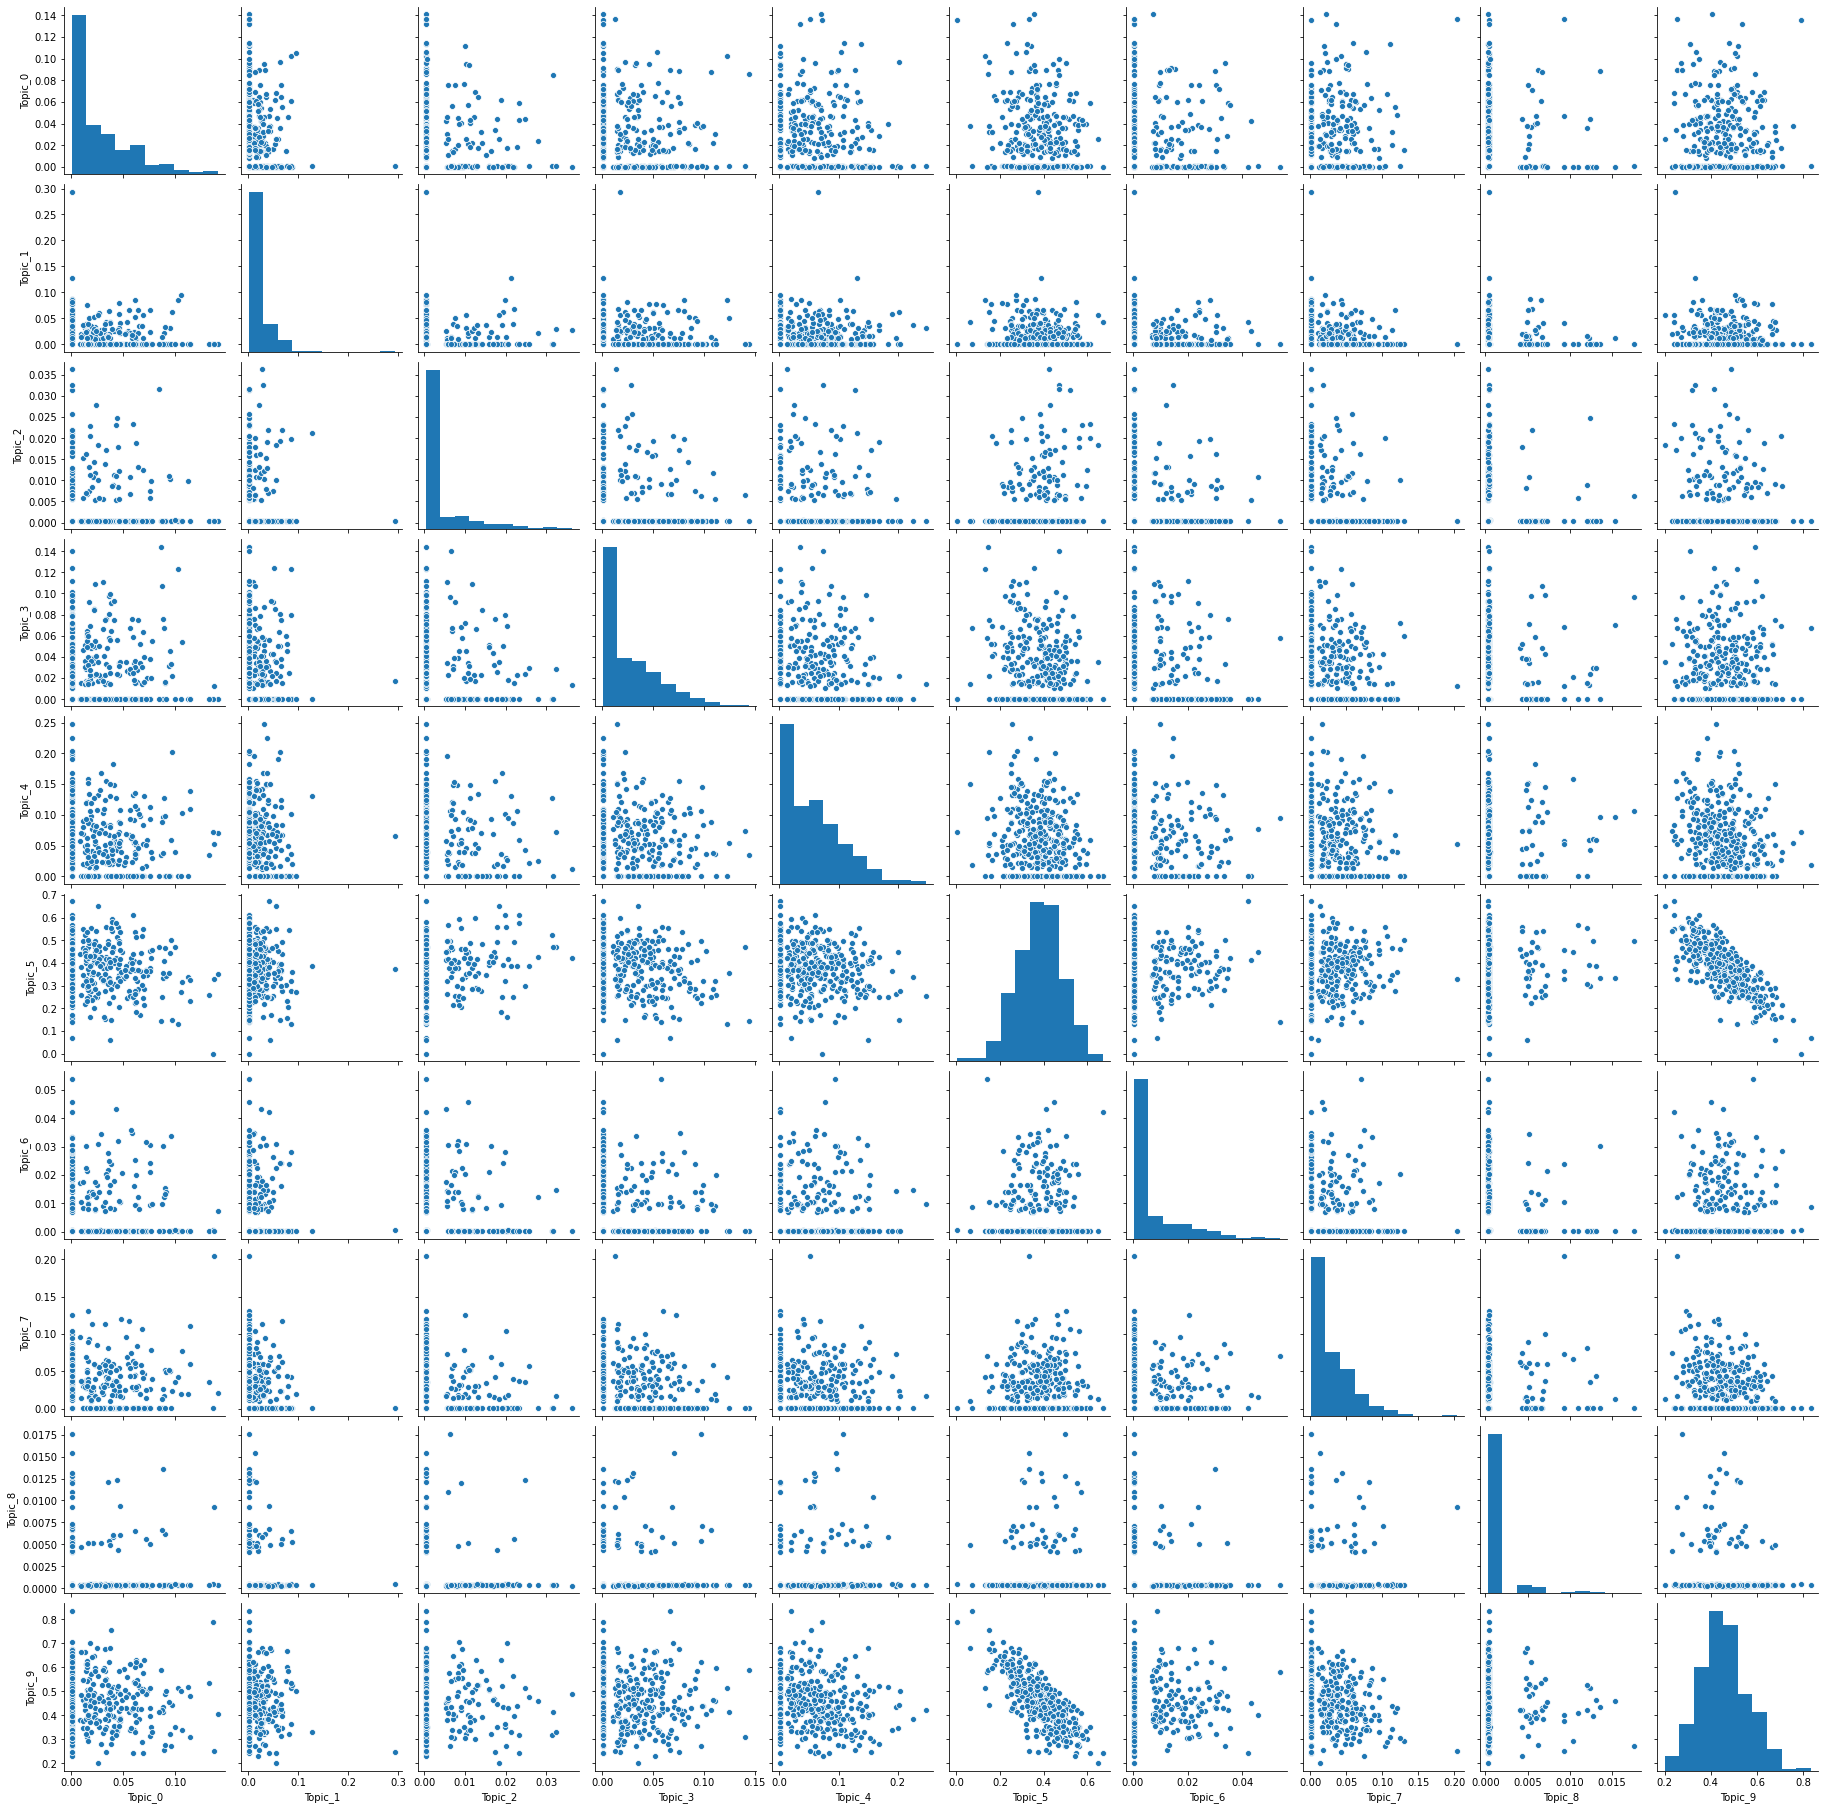

In [18]:
numeric_predictors = [x for x in LDA_test[0].columns if x.startswith("Topic")]
g = sns.pairplot(LDA_test[0][numeric_predictors])

In [19]:
merged_data = pd.merge(test,LDA_test[0], on='headlines')
merged_data

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,2015-01-02,1,most cases cancer result sheer bad luck rather...,iran dismissed united states efforts fight isl...,poll one germans would join anti muslim ma...,uk royal family s prince andrew named us laws...,some asylum seekers refused leave bus arriv...,pakistani boat blows self india navy chase a...,sweden hit third mosque arson attack week,cars set alight french new year,...,0.140795,0.000335,0.000335,0.000335,0.070146,0.353917,0.007252,0.021017,0.000335,0.405535
1,2015-01-05,0,moscow gt beijing high speed train reduce...,two ancient tombs discovered egypt sunday on...,china complains pyongyang n korean soldier kil...,scotland headed towards being fossil fuel free...,prime minister shinzo abe said monday express ...,sex slave centre prince andrew scandal fled au...,gay relative hamas founder faces deportation c...,the number female drug addicts iran almost dou...,...,0.065738,0.000344,0.000344,0.052137,0.098534,0.170565,0.000344,0.000344,0.000344,0.611307
2,2015-01-06,0,us oil falls barrel,toyota gives away fuel cell patents buil...,young indian couple granted police protection ...,a senior figure islamic states self declared p...,fukushima rice passes radiation tests st time...,nearly spanish parties guilty financial crimes...,king abdullah abdicate saudi throne,taliban commander caught networking on linkedin,...,0.000399,0.031872,0.000398,0.000399,0.000399,0.510618,0.000398,0.000399,0.000398,0.454720
3,2015-01-07,1,shots fired french magazine hq,bibi netanyahus campaign funds from u s,isis behead street magician entertaining crowd...,denmark sets new world record renewable energy...,isis closes schools in syria leaving ...,the european union wants turkey explain human ...,people died shooting headquarters french sa...,most earth like planet ever discovered could c...,...,0.000337,0.021947,0.000337,0.037881,0.084072,0.496933,0.000337,0.051354,0.000337,0.306465
4,2015-01-08,1,new charlie hebdo issue come next week it...,ahmed merabet cop killed in paris attacks ...,youngest suspect charlie hebdo attack turns hi...,grenades thrown mosque le mans west paris,danish newspaper print charlie hebdo cartoons ...,muslim politician india offers m charlie he...,vladimir putin condemned deadly terrorist atta...,turkey trying hide evidence holds turkish lead...,...,0.000407,0.000407,0.010721,0.000407,0.077722,0.446621,0.045831,0.015939,0.000407,0.401539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2016-06-27,0,barclays rbs shares suspended trading tanking,pope says church ask forgiveness gays past tre...,poland shocked xenophobic abuse poles uk,there second referendum cabinet agrees,scotland welcome join eu merkel ally says,sterling dips friday s year low amid brexi...,no negative news south african president allow...,surge hate crimes u k following u k s brexit...,...,0.000402,0.012461,0.006645,0.000402,0.099755,0.401509,0.000402,0.043289,0.000402,0.434734
374,2016-06-28,1,scientists to australia if you want to...,the personal details french police off...,s amp p cuts united kingdom sovereign cred...,huge helium deposit found africa,ceo south african state broadcaster quits shor...,brexit cost investors trillion worst one...,hong kong democracy activists call return brit...,brexit iceland president says uk join trian...,...,0.036736,0.011263,0.000357,0.000357,0.130330,0.316014,0.008310,0.000357,0.000357,0.495918
375,2016-06-29,1,explosion at airport in istanbul,yemeni former president terrorism offspring ...,uk must accept freedom movement access eu market,devastated scientists late captive breed mam...,british labor party leader jeremy corbyn loses...,a muslim shop uk was just firebombed while peo...,mexican authorities sexually torture women prison,uk shares pound continue recover,...,0.000400,0.000400,0.009982,0.072367,0.000400,0.462999,0.020478,0.125

In [26]:
with pm.Model() as logistic_model:
    
        #data = pm.Data("data",merged_data)
        Y=merged_data["Label"]
        pm.glm.GLM.from_formula('Y ~ Topic_0+Topic_1+Topic_2+Topic_3+Topic_4+Topic_5+Topic_6+Topic_7+Topic_8+Topic_9', merged_data, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000,step = pm.NUTS(target_accept = 0.9), cores =4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Topic_9, Topic_8, Topic_7, Topic_6, Topic_5, Topic_4, Topic_3, Topic_2, Topic_1, Topic_0, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 316 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
